In [1]:
#Step 1: Create a Fraud Dataset
import pandas as pd
import numpy as np

# Simulate 1000 transactions
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    'Amount': np.random.exponential(scale=100, size=n),
    'Is_Foreign': np.random.binomial(1, 0.1, size=n),
    'Is_High_Risk_Country': np.random.binomial(1, 0.05, size=n),
    'Daily_Transactions': np.random.poisson(2, size=n),
    'Hour': np.random.randint(0, 24, size=n)
})

# Generate fraud label
df['Fraud'] = (
    (df['Amount'] > 180).astype(int)
    + df['Is_Foreign']
    + df['Is_High_Risk_Country']
    + (df['Daily_Transactions'] > 3).astype(int)
    + (df['Hour'] < 6).astype(int)
)
df['Fraud'] = (df['Fraud'] > 2).astype(int)


In [2]:
#Step 2: Apply SMOTE for Balancing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop(columns='Fraud')
y = df['Fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample fraud cases
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)


In [3]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_resampled, y_resampled)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_resampled, y_resampled)

# Predict probabilities
logreg_probs = logreg.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:56:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [4]:
#Step 3: Train Logistic Regression & XGBoost
from sklearn.metrics import roc_auc_score, confusion_matrix

# AUC
print("Logistic AUC:", roc_auc_score(y_test, logreg_probs))
print("XGBoost AUC:", roc_auc_score(y_test, xgb_probs))

# Confusion Matrix at threshold = 0.5
threshold = 0.5
print("Logistic Confusion Matrix:")
print(confusion_matrix(y_test, logreg_probs >= threshold))

print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_probs >= threshold))


Logistic AUC: 0.9375
XGBoost AUC: 0.9627568493150687
Logistic Confusion Matrix:
[[260  32]
 [  2   6]]
XGBoost Confusion Matrix:
[[281  11]
 [  4   4]]


In [5]:
#Step 4: Evaluate with AUC and Confusion Matrix
def fraud_cost(tp, fp, fn, tn):
    return tp*100 + fp*(-10) + fn*(-200)

thresholds = np.arange(0.1, 0.91, 0.1)
for t in thresholds:
    preds = (xgb_probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"Threshold {t:.1f} → Cost: {fraud_cost(tp, fp, fn, tn)}")


Threshold 0.1 → Cost: -220
Threshold 0.2 → Cost: -210
Threshold 0.3 → Cost: -210
Threshold 0.4 → Cost: -510
Threshold 0.5 → Cost: -510
Threshold 0.6 → Cost: -500
Threshold 0.7 → Cost: -490
Threshold 0.8 → Cost: -490
Threshold 0.9 → Cost: -470


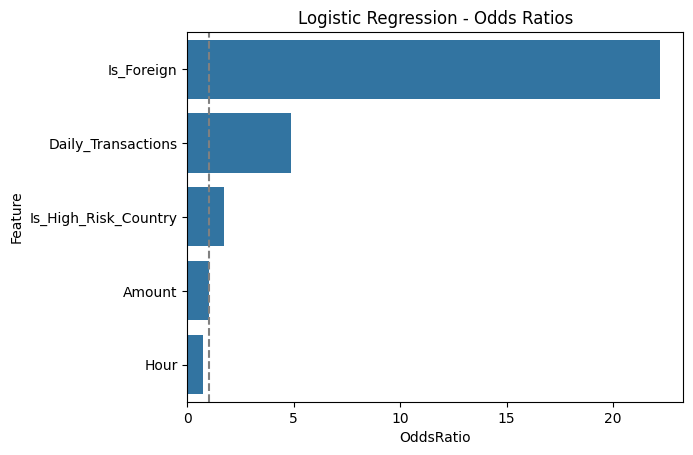

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': logreg.coef_[0],
    'OddsRatio': np.exp(logreg.coef_[0])
}).sort_values('OddsRatio', ascending=False)

sns.barplot(data=coef_df, x='OddsRatio', y='Feature')
plt.axvline(1, color='gray', linestyle='--')
plt.title("Logistic Regression - Odds Ratios")
plt.show()


<ipython-input-7-36dfb236f224>:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


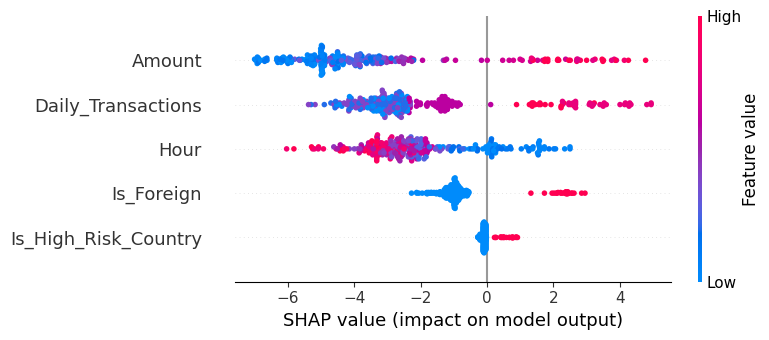

In [7]:
#Step 5: Threshold Tuning + Cost Calculation
!pip install shap
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


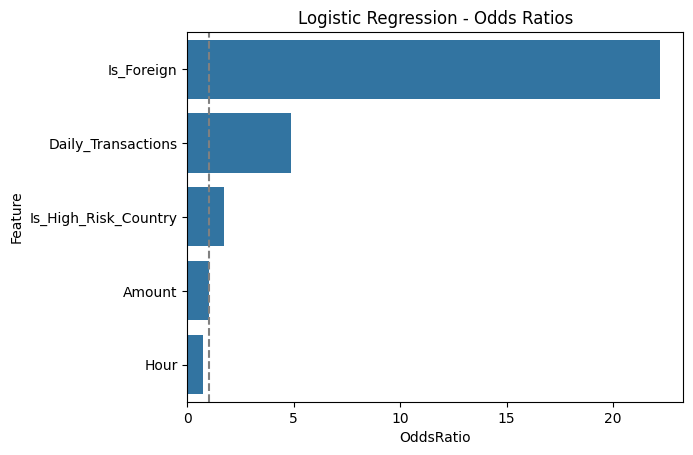

In [9]:
# Step 6: Interpret Logistic Regression Coefficients
import seaborn as sns
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coef': logreg.coef_[0],
    'OddsRatio': np.exp(logreg.coef_[0])
}).sort_values('OddsRatio', ascending=False)

sns.barplot(data=coef_df, x='OddsRatio', y='Feature')
plt.axvline(1, color='gray', linestyle='--')
plt.title("Logistic Regression - Odds Ratios")
plt.show()


<ipython-input-10-b069acd769a4>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


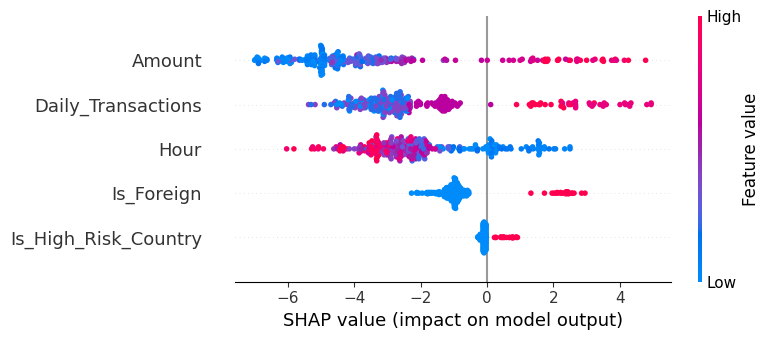

In [10]:
#Step 7: Explain XGBoost with SHAP
!pip install shap
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


In [11]:
#🧪 Step 8: (Optional) Streamlit Threshold App
# Save this as app.py and run using: streamlit run app.py
import streamlit as st
from sklearn.metrics import confusion_matrix

threshold = st.slider("Select threshold", 0.0, 1.0, 0.5)
preds = (xgb_probs >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

cost = fraud_cost(tp, fp, fn, tn)
st.metric("Total Cost", cost)
st.write("TP:", tp, "| FP:", fp, "| FN:", fn, "| TN:", tn)


ModuleNotFoundError: No module named 'streamlit'